# Introduction

This document provides a brief analysis of machine learning techniques applied to a dataset of sensor readings and aerodynamic load of a racing car.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Loading the data

The data is found in `dataset.csv`. It contains 248 readings of 395 sensors. Each reading has a Load value, which is the actual aerodynamic load of the car when the reading was performed.

Here, we acquire the X and y values, representing the sensor readings (features) and the load (target). Then, the readings are split into 200 training samples and 47 test samples.

With the data on hand, we plot a simple chart showing the mean average of all sensor data in each reading on the X axis, and the target Load value on the Y axis.

In [2]:
dataset = pd.read_csv("dataset.csv")

X, y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, 
                                                    test_size=47, random_state=1)

import matplotlib.pyplot as plt

plt.plot(X.mean(axis=1), y, 'o')
plt.xlabel("Mean average of features")
plt.ylabel("Target")

Text(0, 0.5, 'Target')

# Linear Regression

Manual analysis of the dataset shows one interesting fact: all the features are of the same "kind". That is, they are all measuring the same type of data with the same type of sensor. This is why the simple approach of averaging the features works. In general, this would be a bad idea if the features were measuring different kinds of information.

Another interesting fact of the dataset is that it has a very large amount of features for a rather small number of readings. This increases the risk of finding a model that overfits the data, which would cause it to generalize poorly to new data. We will see if this is the case here.

Regardless, from the plot above, it is quite clear that the data has a somewhat linear shape, and, therefore, linear regression might provide us with good predictions for new data.

To apply linear regression, we use `scikit-learn`'s `LinearRegression` module. After fitting the data, we can check the parameters of the model. In the plot, we see the coefficients, which are the weights given to each feature: all of them are in the range between -0.3 and 0.3, meaning that there is a small variance of importance among the features. These values determine the slope of the linear regression model. Meanwhile, the intercept parameter determines the offset of the model. 

To validate the model, we check its scores against the training and test set. The score is perfect on the training set, and is still very high (with over 99% accuracy) on the test set. Despite the high dimensionality of the dataset, the model seems to generalize well to new information.

However, accuracy does not make a lot of sense for regression. So, we can check the error of the model using the mean squared error, which is what the linear regression attempts to minimize. Clearly, the error for the training set is zero, while the error for the test set is around 6, which is small considering the target is in a range of several hundred.


Intercept: 82.09046885046786
Training set score: 1.000000
Test set score: 0.994806
Training set error: 0.000000
Test set error: 5.979539


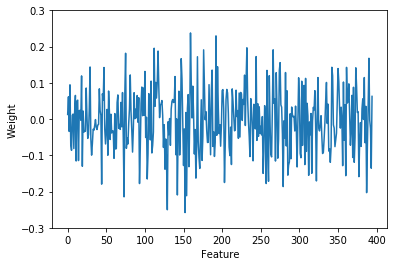

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(X_train, y_train)

plt.plot(lr.coef_)
plt.ylim(-0.3, 0.3)
plt.xlabel("Feature")
plt.ylabel("Weight")

print("Intercept: {}".format(lr.intercept_))

print("Training set score: {:f}".format(lr.score(X_train, y_train)))
print("Test set score: {:f}".format(lr.score(X_test, y_test)))

y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)
print("Training set error: {:f}".format(mean_squared_error(y_train_pred, y_train)))
print("Test set error: {:f}".format(mean_squared_error(y_pred, y_test)))

## Cross-Validation

Cross-validation is a technique that allows us to check how well a model generalizes to new data by training and testing it with different "folds" of the dataset.

Here, we perform a 10-fold split, meaning we split the data into 10 parts and train the model 10 times. Each training step uses nine folds as training set and one as test set, so each data point is part of the test set exactly once.

This process is abstracted away using `scikit-learn`'s `cross_val_score` method, using negated mean squared errors as a scoring method. We can see that some of the folds provide much better generalization than others: while using fold 3 as the test set gave us an error of less than 6, fold 5 resulted in an error almost three times larger. This might indicate that fold 5 contains the most difficult data in the set.

Average cross-validation error: -10.568687533537567


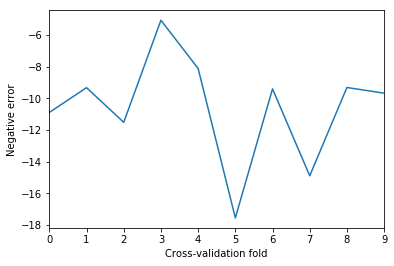

In [4]:
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
scores = cross_val_score(lr, X, y, cv=10, scoring='neg_mean_squared_error')
plt.plot(scores)
plt.xlim(0, 9)
plt.xlabel("Cross-validation fold")
plt.ylabel("Negative error")

print("Average cross-validation error: {}".format(scores.mean()))

# Ridge Regression

Ridge regression is a variation of linear regression in which the weights of the features are somewhat bounded: we don't want to give any feature very high importance in the result, but we want every feature to have some importance. We can use `scikit-learn`'s `Ridge` model for this.

In [9]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
print("Training set error: {:f}"
      .format(mean_squared_error(y_train_pred, y_train)))

Training set error: 0.000391


## Cross-Validation and Grid Search

Ridge regression is tuned by one important parameter, the alpha. It dictates how strongly bounded the weights will be. The closer this value is to 0, the closer the prediction will be to a standard linear regression.

Here, we use a grid search technique to try different values of alpha and find the model with the best performance. We use sample values between 0.001 and 20000 to find a suitable value of alpha.

Furthermore, we apply cross-validation for each set of alpha. To estimate the best alpha, we choose the one that has the highest average score across the cross-validation samples.

In this experiment, the alpha=1000 performs the best, meaning that the weights of the features are quite restricted. The plot shows how small the values of the coefficients end up being.

In [22]:
best_score = -100

for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 20000]:
    ridge = Ridge(alpha=alpha)

    scores = cross_val_score(ridge, X_train, y_train, cv=10,
                             scoring='neg_mean_squared_error')
    
    score = np.mean(scores)
    
    print("Error with alpha={:.3f}: {:f}"
          .format(alpha, score))
    
    if score > best_score:
        best_score = score
        best_parameters = {'alpha': alpha}

ridge = Ridge(**best_parameters)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
test_score = ridge.score(X_test, y_test)

print("Best error on cross-validation: {:f}"
      .format(best_score))
print("Best parameters: "
      , best_parameters)
print("Test set error with best parameters: {:f}"
      .format(mean_squared_error(y_pred, y_test)))

Error with alpha=0.001: -4.728829
Error with alpha=0.010: -4.727961
Error with alpha=0.100: -4.719321
Error with alpha=1.000: -4.637475
Error with alpha=10.000: -4.105039
Error with alpha=100.000: -3.152956
Error with alpha=1000.000: -2.745261
Error with alpha=10000.000: -3.068393
Error with alpha=20000.000: -3.494026
Best error on cross-validation: -2.745261
Best parameters:  {'alpha': 1000}
Test set error with best parameters: 2.653045


Text(0, 0.5, 'Weight')

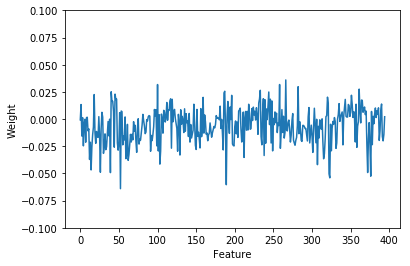

In [23]:
plt.plot(ridge.coef_)
plt.ylim(-0.1, 0.1)
plt.xlabel("Feature")
plt.ylabel("Weight")

# Lasso Regression

In [7]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
print("Training set error: {:f}"
      .format(mean_squared_error(y_train_pred, y_train)))
print("Test set error: {:f}"
      .format(mean_squared_error(y_pred, y_test)))

Training set error: 1.826553
Test set error: 2.924963


## Cross-validation and Grid Search

In [10]:
best_score = -100

for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    for max_iter in [1000, 10000, 100000, 1000000, 10000000, 100000000]:
        lasso = Lasso(alpha=alpha, max_iter=max_iter)

        scores = cross_val_score(lasso, X_train, y_train, cv=10,
                                 scoring='neg_mean_squared_error', n_jobs=-1)

        score = np.mean(scores)

        print("Score with alpha={:.3f} and max_iter={:.0f}: {:f}"
              .format(alpha, max_iter, score))

        if score > best_score:
            best_score = score
            best_parameters = {'alpha': alpha, 'max_iter': max_iter}

lasso = Lasso(**best_parameters)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
test_score = lasso.score(X_test, y_test)

print("Best score on cross-validation: {:f}"
      .format(best_score))
print("Best parameters: ",
      best_parameters)
print("Test set error with best parameters: {:f}"
      .format(mean_squared_error(y_pred, y_test)))

Score with alpha=0.001 and max_iter=1000: -2.643436
Score with alpha=0.001 and max_iter=10000: -4.477828
Score with alpha=0.001 and max_iter=100000: -4.477828
Score with alpha=0.001 and max_iter=1000000: -4.477828
Score with alpha=0.001 and max_iter=10000000: -4.477828
Score with alpha=0.001 and max_iter=100000000: -4.477828
Score with alpha=0.010 and max_iter=1000: -2.695169
Score with alpha=0.010 and max_iter=10000: -2.032351
Score with alpha=0.010 and max_iter=100000: -3.321821
Score with alpha=0.010 and max_iter=1000000: -3.321821
Score with alpha=0.010 and max_iter=10000000: -3.321821
Score with alpha=0.010 and max_iter=100000000: -3.321821
Score with alpha=0.100 and max_iter=1000: -2.003120
Score with alpha=0.100 and max_iter=10000: -2.215631
Score with alpha=0.100 and max_iter=100000: -2.215631
Score with alpha=0.100 and max_iter=1000000: -2.215631
Score with alpha=0.100 and max_iter=10000000: -2.215631
Score with alpha=0.100 and max_iter=100000000: -2.215631
Score with alpha=1.

/Users/renangreca/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0, 0.5, 'Weight')

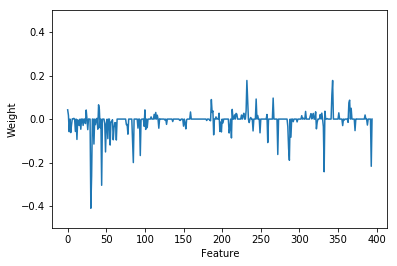

In [21]:
plt.plot(lasso.coef_)
plt.ylim(-0.5, 0.5)
plt.xlabel("Feature")
plt.ylabel("Weight")